In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import psutil

In [2]:
def spin_rotate(de, T, spin, Kb = 1.0):
    if de <= 0:
        spin = -spin
    else:
        Z = np.exp(-(de)/(Kb*T))
        r = np.random.random()
        if r < Z:
            spin = -spin
    return spin

In [3]:
def wolff(grid, T, J = 1.0, Kb = 1.0):
    up = np.argwhere(grid == 1)
    down = np.argwhere(grid == -1)

    nl_x, nl_y = np.shape(grid)

    x = np.random.randint(1, nl_x - 1)
    y = np.random.randint(1, nl_y - 1)

    while True:
        if grid[x, y] == 1:
            working_space = set(list(map(tuple, up)))
            spin = 1
            break
        elif grid[x, y] == -1:
            working_space = set(list(map(tuple, down)))
            spin = -1
            break
        else:
            continue

    p_add = 1 - np.exp((-2)*J/(Kb*T))

    cluster = [[x, y]]
    stack = [[x, y]]

    while True:
        seed = stack.pop()
        lst = [[seed[0] + 1, seed[1]], [seed[0] - 1, seed[1]], 
               [seed[0], seed[1] + 1], [seed[0], seed[1] - 1]]
        
        #lst_set = set(list(map(tuple, lst)))
        not_in_cluster = set(map(tuple, (filter(lambda x: x not in cluster, lst))))

        intersection_of_lst_and_not = not_in_cluster.intersection(working_space)
        for j in intersection_of_lst_and_not:         
            a = np.random.random()
            if a < p_add:
                cluster.append(list(j))
                stack.append(list(j))
            else:
                pass
                
        if len(stack) == 0:
            break

    c = np.array(cluster).T
    grid[c[0], c[1]] = -spin

    return grid

In [4]:
def Energy(grid):
    e = np.sum(-grid[1 : -1, 1 : -1]*(grid[0 : -2, 1 : -1] + grid[2 : , 1 : -1]
                                      + grid[1 : -1, 0 : -2] + grid[1 : -1, 2 : ]))/2
    
    return e

In [5]:
def R_square(y_predic, y_origin):
    A = np.sum((y_predic - y_origin)**2)
    B = np.sum((y_origin - np.mean(y_origin))**2)

    return 1 - A/B

In [6]:
# Process实例化时不指定pid参数，默认使用当前进程PID，即os.getpid()
p = psutil.Process()
cpu_lst = p.cpu_affinity()
print("cpu列表", cpu_lst)
# 将当前进程绑定到cpu15上运行，列表中也可以写多个cpu
p.cpu_affinity([0])

cpu列表 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [7]:
nl = 42
J = 1.0
Kb = 1.0
T0 = 0.5
dT = 0.01
nre1 = 500
ncount1 = 1000
nre2 = 50000
ncount2 = 100000
nre3 = 10000
ncount3 = 20000
grid_point = np.zeros([nl, nl])
T = np.arange(T0, 7.0, dT)
Energy0 = []
Mag = []
Cv = []
TT = []

print('a')

# 设置初始自旋状态
for i in range(nl):
    for j in range(nl):
        r1 = np.random.random()
        if r1 >= 0.5:
            grid_point[i, j] = 1
        else:
            grid_point[i, j] = -1

#设置周期性边界条件
for i in range(1, nl-1):
    grid_point[i, nl-2] = grid_point[i, 0]
    grid_point[i, nl-1] = grid_point[i, 1]
for j in range(nl):
    grid_point[nl-2, j] = grid_point[0, j]
    grid_point[nl-1, j] = grid_point[1, j]

for T1 in np.arange(T0, 7.0, dT):
    if T1 <= 2.0:
        nre = nre1
        ncount = ncount1
        if (T1*100 - T0*100) % (1000*dT) >= 0.5:
            #print(T1)
            continue 
        else:
            pass
    elif 2.0 < T1 <= 2.5:
        nre = nre2
        ncount = ncount2
    else:
        nre = nre3
        ncount = ncount3
        if (T1*100 - T0*100) % (1000*dT) >= 0.5:
            continue 
        else:
            pass

    #print(T1)
    # 热弛豫
    for n in range(nre):
       
        grid_point = wolff(grid_point, T1)
        # 更新周期性边界条件
        for i in range(1, nl-1):
            grid_point[i, nl-2] = grid_point[i, 0]
            grid_point[i, nl-1] = grid_point[i, 1]
        for j in range(nl):
            grid_point[nl-2, j] = grid_point[0, j]
            grid_point[nl-1, j] = grid_point[1, j]
        
    #计算步
    sum_energy = 0
    sum_energy2 = 0
    sum_Mag = np.sum(grid_point[1:nl-1, 1:nl-1])
    for n in range(ncount):
        grid_point = wolff(grid_point, T1)
        # 更新周期性边界条件
        for i in range(1, nl-1):
            grid_point[i, nl-2] = grid_point[i, 0]
            grid_point[i, nl-1] = grid_point[i, 1]
        for j in range(nl):
            grid_point[nl-2, j] = grid_point[0, j]
            grid_point[nl-1, j] = grid_point[1, j]
        
        #计算体系能量
        sum_energy += (Energy(grid_point))
        sum_energy2 += Energy(grid_point)**2
        sum_Mag += abs(np.sum(grid_point[1:nl-1, 1:nl-1]))

    E1 = sum_energy/ncount
    E2 = sum_energy2/ncount
    cv = (E2 - E1**2)/(Kb*T1**2)/(nl - 2)**2

    sum_energy = E1/(nl - 2)**2

    sum_Mag = sum_Mag/(ncount*(nl - 2)**2)

    Energy0.append(sum_energy)
    Mag.append(sum_Mag)
    Cv.append(cv)
    TT.append(T1)

    print(T1, sum_energy, sum_Mag, cv)

a
0.5 -1.999993125 0.99899875 0.00016719749663025141
0.6000000000000001 -1.99997375 0.99899375 0.0005559652765643678
0.7000000000000002 -1.9998262500000001 0.9989575 0.00281468877445298
0.8000000000000003 -1.9993975 0.9988475 0.008119828124108603
0.9000000000000004 -1.998206875 0.99853625 0.018555431327794053
1.0000000000000004 -1.995889375 0.99792 0.03485379437566732
1.1000000000000005 -1.991788125 0.998825 0.05638826394661455
1.2000000000000006 -1.9852525 0.99503875 0.0879465208337124
1.3000000000000007 -1.9748750000000002 0.9921425 0.12827588757362268
1.4000000000000008 -1.9592025000000002 0.98953125 0.18604968877494962
1.5000000000000009 -1.9385425 0.981055 0.2360304933331076
1.600000000000001 -1.909765625 0.9716775 0.33829110717761024
1.700000000000001 -1.8740631250000002 0.9611675 0.46254930774170433
1.8000000000000012 -1.82458875 0.93947 0.5910306782407799
1.9000000000000012 -1.762065 0.91185625 0.7850075457062899
2.0000000000000013 -1.67715741875 0.8603615375 1.050510791172563


KeyboardInterrupt: 

In [9]:
TT = []
for T1 in np.arange(T0, 7.0, dT):
    if T1 <= 2.0:
        nre = nre1
        ncount = ncount1
        if (T1*100 - T0*100) % (1000*dT) >= 0.5:
            #print(T1)
            continue 
        else:
            pass
    elif 2.0 < T1 <= 2.5:
        nre = nre2
        ncount = ncount2
    else:
        nre = nre3
        ncount = ncount3
        if (T1*100 - T0*100) % (1000*dT) >= 0.5:
            continue 
        else:
            pass
    TT.append(T1)

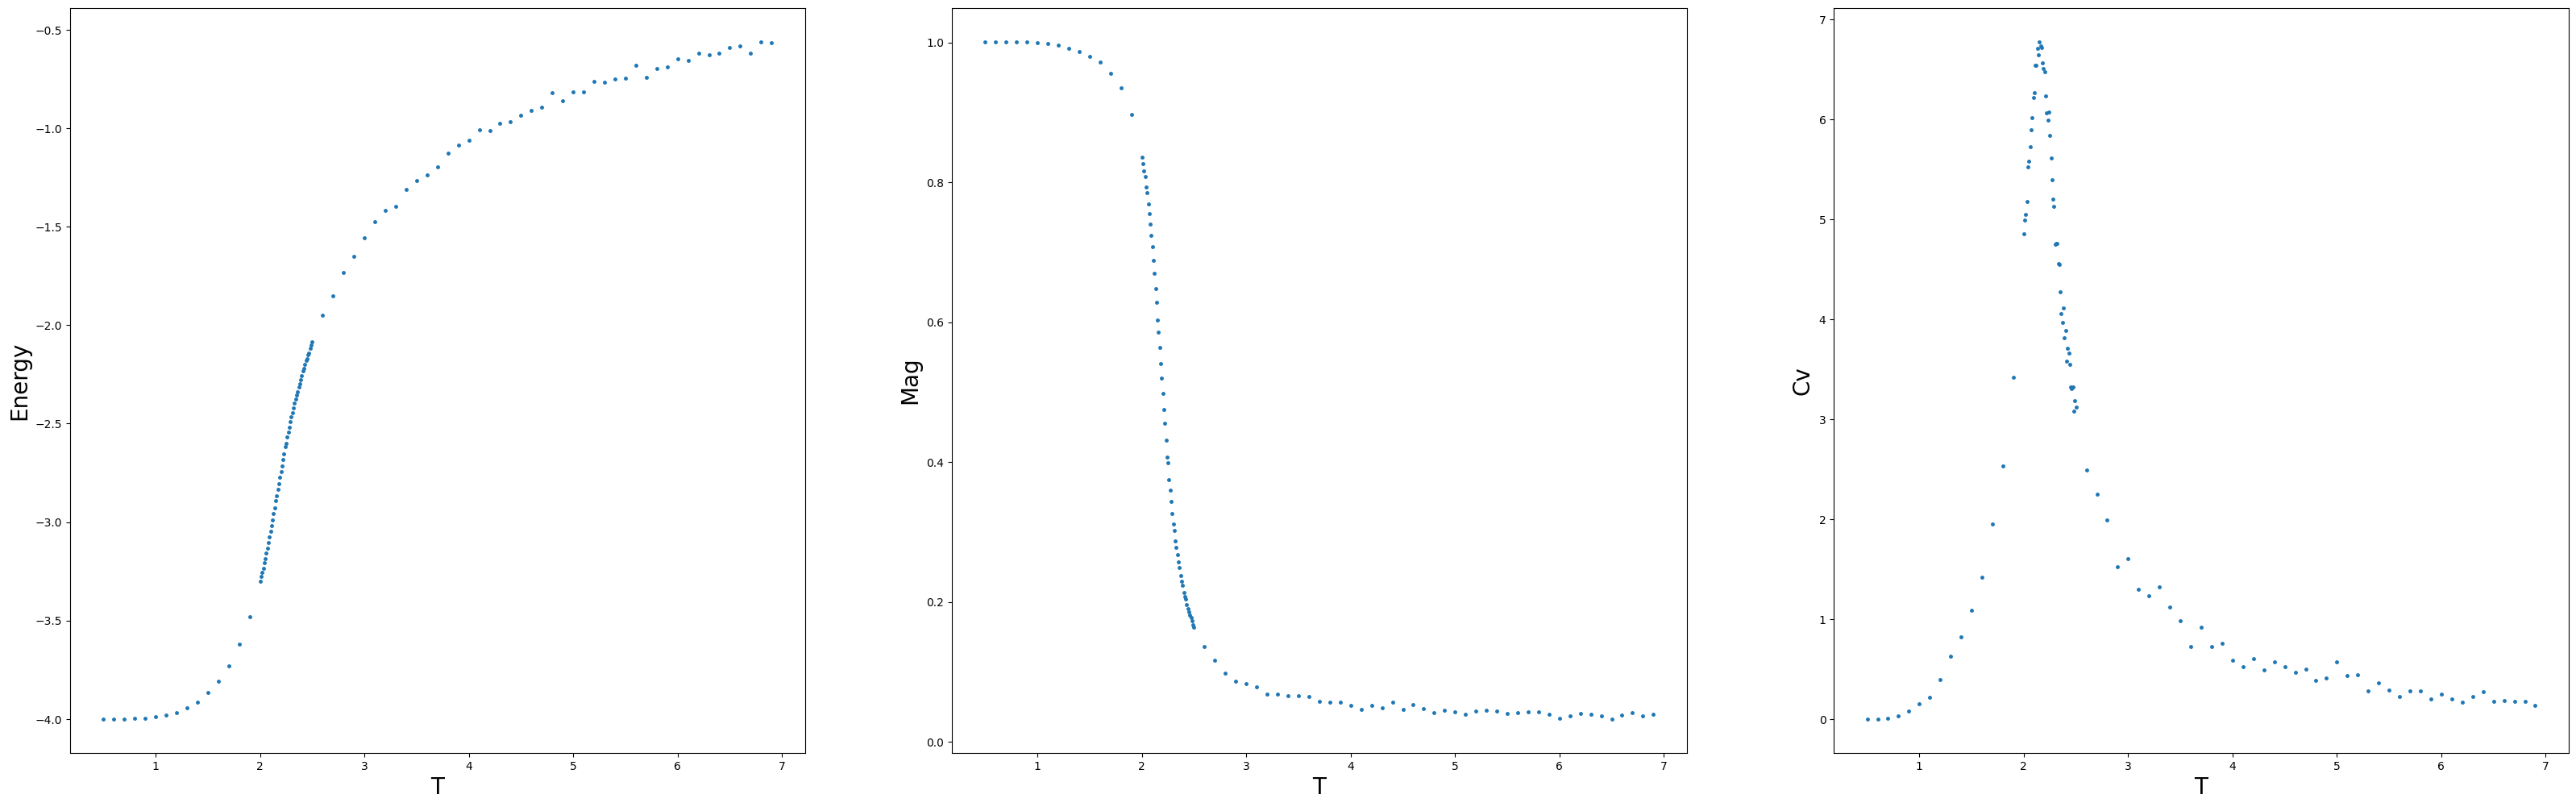

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (40, 12))

ax[0].plot(TT, -np.array(Energy0), 'o', ms = 2.5)
ax[0].set_xlabel('T', fontsize = 20)
ax[0].set_ylabel('Energy', fontsize = 20)
ax[1].plot(TT, Mag, 'o', ms = 2.5)
ax[1].set_xlabel('T', fontsize = 20)
ax[1].set_ylabel('Mag', fontsize = 20)
ax[2].plot(TT, Cv, 'o', ms = 2.5)
ax[2].set_xlabel('T', fontsize = 20)
ax[2].set_ylabel('Cv', fontsize = 20)

plt.show()

In [ ]:
txt_file = []

for i in range(len(TT)):
    aa = str(TT[i]) + ' ' + str(Energy0[i]) + ' ' +  str(Mag[i]) + ' ' +  str(Cv[i]) + '\n'
    txt_file.append(aa)

with open(r"../data/rect_renewed.txt","w") as f:
    for i in txt_file:
        f.write(i)  # 自带文件关闭功能，不需要再写f.close()

In [11]:
pa = '../data'
file_path = os.listdir(pa)

file_path1 = []
for i in file_path:
    if i.endswith('renewed.txt'):
        file_path1.append(i)

Energy0_tri = []
Energy0_rect = []
Energy0_hexa = []
Mag_tri = []
Mag_rect = []
Mag_hexa = []
Cv_tri = []
Cv_rect = []
Cv_hexa = []
T_tri = []
T_rect = []
T_hexa = []


with open(r'../data/' + file_path1[0], 'r') as fp:
    a = fp.readlines()
for i in a:
    t, energy, mag, cv = tuple(map(eval, i.split()))
    Energy0_hexa.append(-energy/2)
    Mag_hexa.append(mag)
    Cv_hexa.append(cv/4)
    T_hexa.append(t)

with open(r'../data/' + file_path1[1], 'r') as fp:
    a = fp.readlines()
for i in a:
    t, energy, mag, cv = tuple(map(eval, i.split()))
    Energy0_rect.append(-energy/2)
    Mag_rect.append(mag)
    Cv_rect.append(cv/4)
    T_rect.append(t)

with open(r'../data/' + file_path1[2], 'r') as fp:
    a = fp.readlines()
for i in a:
    t, energy, mag, cv = tuple(map(eval, i.split()))
    Energy0_tri.append(-energy/2)
    Mag_tri.append(mag)
    Cv_tri.append(cv/4)
    T_tri.append(t)

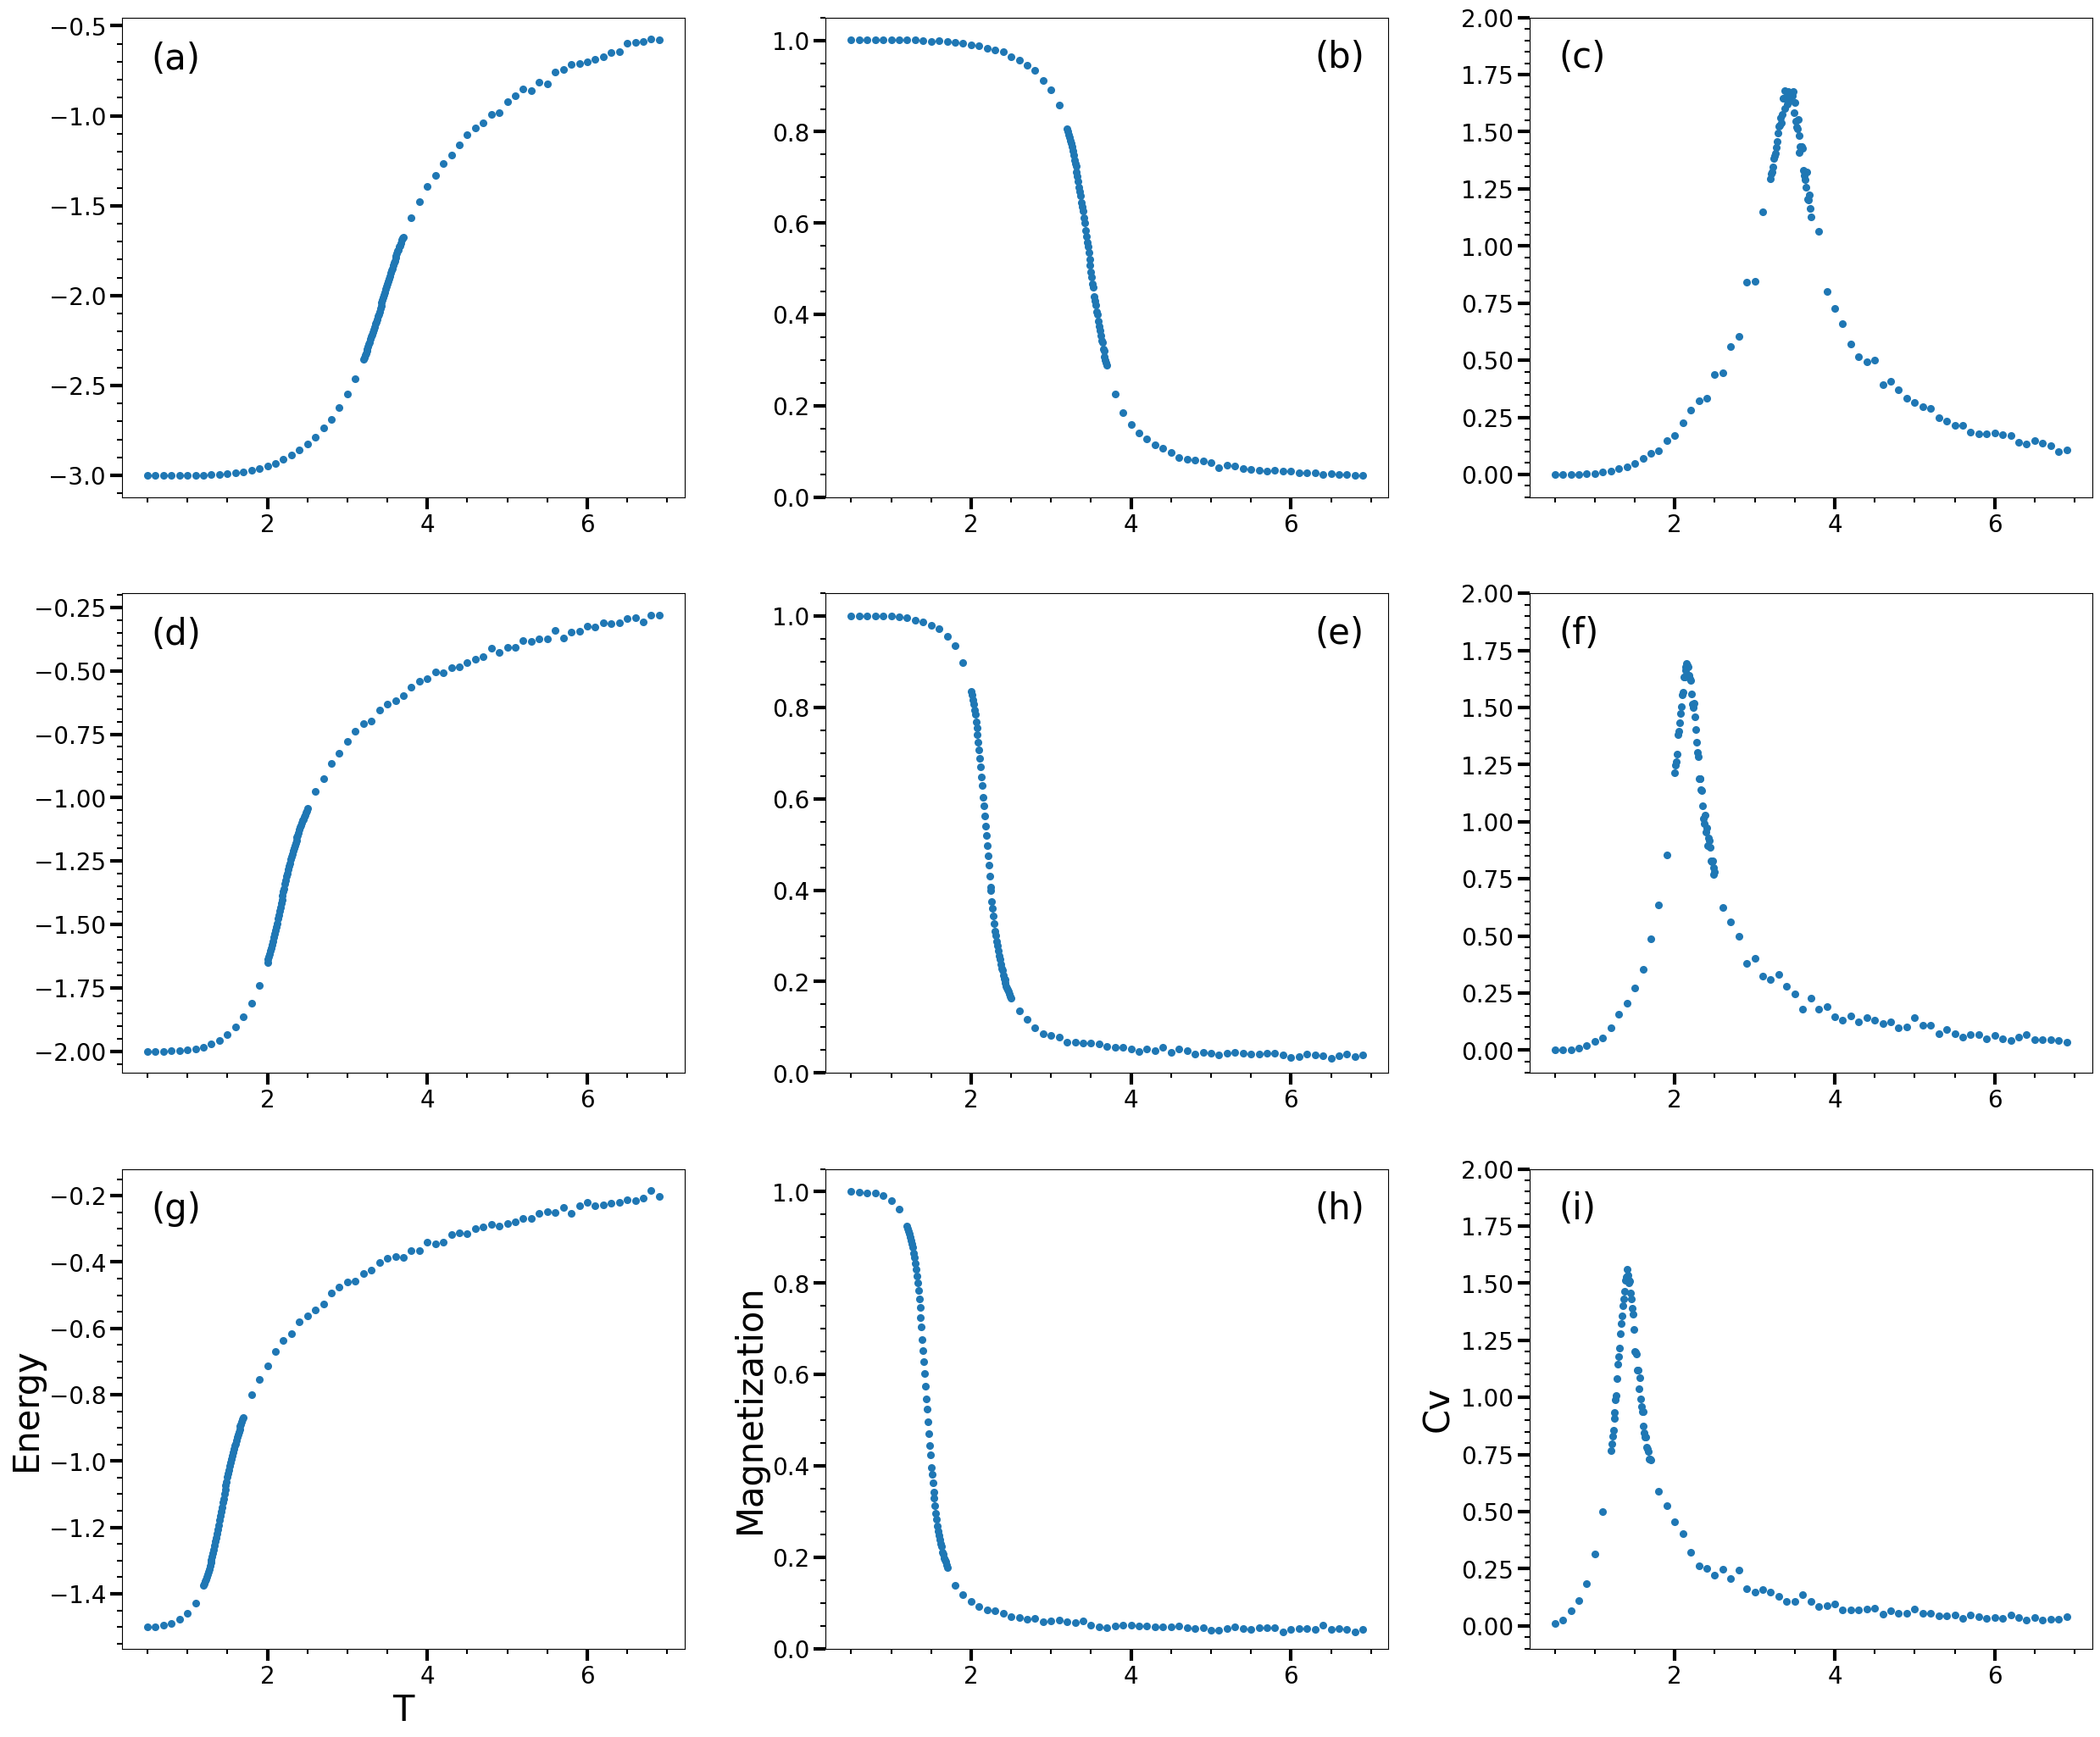

In [15]:
T_lst = [T_tri, T_rect, T_hexa]
plot_lst = [[Energy0_tri, Mag_tri, Cv_tri], [Energy0_rect, Mag_rect, Cv_rect], 
[Energy0_hexa, Mag_hexa, Cv_hexa]]
label_lst = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']

fig, ax = plt.subplots(3, 3, figsize = (30, 25))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(T_lst[i], plot_lst[i][j], 'o', markersize = 5.5)
        if i == 2:
            if j == 0:
                ax[i][j].set_ylabel(r'Energy', fontsize = 30)
                ax[i][j].set_xlabel('T', fontsize = 30)
            if j == 1:
                ax[i][j].set_ylabel(r'Magnetization', fontsize = 30)
            if j == 2:
                ax[i][j].set_ylabel(r'Cv', fontsize = 30)

        ax[i][j].minorticks_on()
        ax[i][j].tick_params(axis='x', labelsize = 20, which = 'major', width = 3, length = 10)
        ax[i][j].tick_params(axis='x', labelsize = 20, which = 'minor', width = 1.5, length = 4)
        ax[i][j].tick_params(axis='y', labelsize = 20, which = 'major', width = 3, length = 10)
        ax[i][j].tick_params(axis='y', labelsize = 20, which = 'minor', width = 1.5, length = 4)

        if j == 1:
            ax[i][j].set_ylim(-0.0, 1.05)

        if j == 2:
            ax[i][j].set_ylim(-0.1, 2.0)
        
ax[0][0].text(0.55, -0.74, label_lst[0], fontsize = 30)
ax[0][1].text(6.30, 0.94, label_lst[1], fontsize = 30)
ax[0][2].text(0.55, (2.0+0.1)*(0.94)/1.05 - 0.1, label_lst[2], fontsize = 30)

ax[1][0].text(0.55, -0.395, label_lst[3], fontsize = 30)
ax[1][1].text(6.30, 0.94, label_lst[4], fontsize = 30)
ax[1][2].text(0.55, (2.0+0.1)*(0.94)/1.05 - 0.1, label_lst[5], fontsize = 30)

ax[2][0].text(0.55, -0.27, label_lst[6], fontsize = 30)
ax[2][1].text(6.30, 0.94, label_lst[7], fontsize = 30)
ax[2][2].text(0.55, (2.0+0.1)*(0.94)/1.05 - 0.1, label_lst[8], fontsize = 30)

plt.subplots_adjust(wspace = 0.25)
plt.savefig(r"../TeX\fig\Figure3.pdf", dpi = 320, bbox_inches = 'tight')
plt.show()

2.1500000000000012 -0.05244601145879192
0.12575032614110332 0.006002609128826553 0.9838098417803154


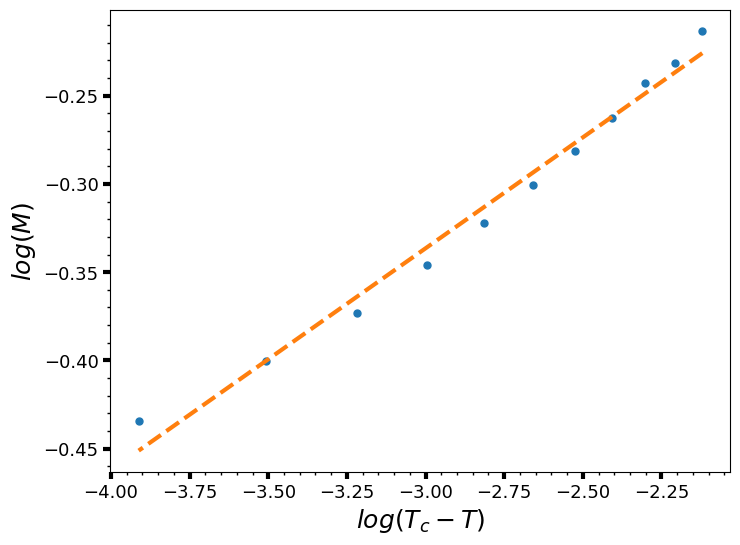

In [81]:
nc = Cv_rect.index(np.max(Cv_rect))
Tc_rect = T_rect[nc]
print(Tc_rect, (Tc_rect - 2.269)/2.269)
n0 = 12
x_rect = np.log(T_rect[nc] - np.array(T_rect[nc - n0 : nc - 1]))
y_rect = np.log(Mag_rect[nc - n0 : nc - 1])
x = np.linspace(x_rect[0], x_rect[-1], 100)

z1 = np.polyfit(x_rect, y_rect, 1) #用3次多项式拟合，输出系数从高到0
p1 = np.poly1d(z1) #使用次数合成多项式
R2 = R_square(p1(x_rect), y_rect)
print(p1[1], (p1[1] - 0.125)/0.125, R2)
y_pre = p1(x)


fig, ax = plt.subplots(figsize = (8, 6))

plt.plot(np.log(T_rect[nc] - np.array(T_rect[nc - n0 : nc - 1])), np.log(Mag_rect[nc - n0 : nc - 1]), '.', ms = 10.0)
plt.plot(x, y_pre, linestyle = 'dashed', lw = 3.0)

ax.set_xlabel(r'$log(T_{c} - T)$', fontsize = 18)
ax.set_ylabel(r'$log(M)$', fontsize = 18)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize = 13, which = 'major', width = 3, length = 5)
ax.tick_params(axis='x', labelsize = 13, which = 'minor', width = 1, length = 2)
ax.tick_params(axis='y', labelsize = 13, which = 'major', width = 3, length = 5)
ax.tick_params(axis='y', labelsize = 13, which = 'minor', width = 1, length = 2)

plt.savefig(r"TeX\fig\Figure4.pdf", dpi = 320, bbox_inches = 'tight')
plt.show()